<a href="https://colab.research.google.com/github/LiHuaqing-tum/Safe-Flow-Matching/blob/main/2D_Safeflow_matching(vision%20without%20legal%20phi%20function).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install cvxpy ecos
import cvxpy as cp
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SafeFlowDataset(Dataset):
    def __init__(self, npz_path, device="cpu"):
        super().__init__()
        self.device = device
        self.raw = np.load(npz_path, allow_pickle=True)["data"]
        self.samples = list(self.raw)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        #数据转化
        start = torch.tensor(sample["start"], dtype=torch.float32)
        goal = torch.tensor(sample["goal"], dtype=torch.float32)
        obstacles = torch.tensor(sample["obstacles"], dtype=torch.float32).flatten()  # [9]
        trajectory = torch.tensor(sample["trajectory"], dtype=torch.float32)  # [H, 2]#数据集中的H大小反映平滑度
        #数据转化
        time_steps = torch.linspace(0, 1, steps=trajectory.shape[0]).unsqueeze(-1)   # [H, 1]
        inputs = torch.cat([time_steps, trajectory], dim=-1)  # [H, 3]

        return inputs, goal, obstacles, trajectory


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn

class SafeFlowNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, hidden_dim),  # 输入: t,x,y和3个圆形障碍物的9个参数（x,y,r）
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)    # 输出速度: dx, dy
        )

    def forward(self, t_x, obstacles):
        B, H, _ = t_x.shape
        obs = obstacles.unsqueeze(1).repeat(1, H, 1)  # 从[B,9]到][B, H, 9]
        inp = torch.cat([t_x, obs], dim=-1)  # [B, H, 12]，把t,x,y和obs拼起来
        return self.net(inp)#最后通过inp算出速度


In [ ]:
import numpy as np
import torch
#可视化
def rollout_trajectory(model, start, obstacles, steps=10, dt=1.0/10):

    device = start.device
    B = start.shape[0]
    x = start
    trajectory = [x]#trajectory起点是start

    for i in range(steps):
        t = torch.full((B, 1), i * dt, dtype=torch.float32, device=device) #所有元素都是i*dt,[B, 1]
        tx = torch.cat([t, x], dim=-1).unsqueeze(1)  # [B, 1, 3]
        v = model(tx, obstacles).squeeze(1)#预测速度
        x = x + dt * v
        trajectory.append(x)#把当前算的trajectory加入其中

    return torch.stack(trajectory, dim=1)#返回轨迹，增加维度拼成大tensor


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train_safeflow(model, dataloader, num_epochs=10, lr=1e-3, device="cpu"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)#选了adam
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for inputs, goal, obstacles, target_traj in pbar:
            inputs = inputs.to(device)              # [B, H, 3]
            obstacles = obstacles.to(device)        # [B, 9]
            target_traj = target_traj.to(device)    # [B, H, 2]

            start = inputs[:, 0, 1:3]  # 提取 t=0 时的 (x0, y0)
            pred_traj = rollout_trajectory(model, start, obstacles, steps=inputs.shape[1] - 1)

            loss = torch.mean((pred_traj - target_traj) ** 2)  # 计算MSE loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()#对这一轮epoch的所有batch的loss求和
            pbar.set_postfix({"loss": loss.item()})#显示进度

        avg_loss = total_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1} finished, avg loss = {avg_loss:.6f}")

    return model


In [ ]:
import cvxpy as cp
import numpy as np

# 计算障碍函数 h(x) 及其梯度 ，针对圆形障碍
def compute_barrier_terms(x, obstacles, phi=10.0):#pi是屏蔽函数的强度因子
    grads = []
    hs = []
    for (cx, cy, r) in obstacles:
        c = np.array([cx, cy])
        h_val = np.sum((x - c)**2) - r**2
        grad_h = 2 * (x - c)
        hs.append(h_val)
        grads.append(grad_h)
    return grads, hs

# 解 QP 最小化 u，确保 FMBF 约束成立
def solve_ut_qp(x, v, obstacles, phi=10.0):
    """
    x: 当前坐标 [2]
    v: 原始速度向量 [2]
    obstacles: [(cx, cy, r), ...]
    返回: 控制修正量 u [2]
    """
    u = cp.Variable(2)
    objective = cp.Minimize(cp.sum_squares(u))
    constraints = []

    grads, hs = compute_barrier_terms(x, obstacles, phi)
    for grad_h, h_val in zip(grads, hs):
        constraint = grad_h @ (v + u) + phi * h_val >= 0
        constraints.append(constraint)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)

    if u.value is not None:
        return u.value.astype(np.float32)
    else:
        return np.zeros(2, dtype=np.float32)  # fallback


In [ ]:
import numpy as np

# 安全 rollout 函数：每一步都加上 solve_ut_qp 返回的控制修正项 u_t
def rollout_trajectory_safe(model, start, obstacles, steps=10, dt=1.0/10, phi=10.0):
    device = start.device
    B = start.shape[0] # Assuming batch size is 1 for visualization
    if B != 1:
        print("Warning: rollout_trajectory_safe designed for batch size 1 in visualization.")

    x = start.clone() # Start position [1, 2]
    # Store as CPU tensor for stacking later, remove batch dim for consistency
    trajectory = [x.squeeze(0).cpu()]
    # Convert obstacles to numpy list of tuples for solve_ut_qp
    obstacles_np = obstacles.squeeze(0).cpu().numpy().reshape(-1, 3) # [9] -> [3, 3]
    obstacles_list = [tuple(obs) for obs in obstacles_np] # [(cx, cy, r), ...]

    model.eval() # Ensure model is in evaluation mode

    for i in range(steps):
        t = torch.full((B, 1), i * dt, dtype=torch.float32, device=device)
        tx = torch.cat([t, x], dim=-1).unsqueeze(1)  # [B, 1, 3]

        with torch.no_grad(): # No need to compute gradients for inference
            v = model(tx, obstacles).squeeze(1)      # [B, 2]

        # Convert current state and predicted velocity to numpy for QP solver
        x_np = x.squeeze(0).cpu().numpy() # [2]
        # Corrected line: call numpy() method
        v_np = v.squeeze(0).cpu().numpy() # [2]

        # Solve QP for control correction u_t
        u_t_np = solve_ut_qp(x_np, v_np, obstacles_list, phi) # [2]

        # Convert u_t back to torch tensor and ensure it's on the correct device
        u_t = torch.tensor(u_t_np, dtype=torch.float32, device=device).unsqueeze(0) # [1, 2]

        # Apply the control correction
        v_safe = v + u_t # [B, 2]

        # Update position
        x = x + dt * v_safe # [B, 2]

        # Append current state to trajectory
        trajectory.append(x.squeeze(0).cpu())

    # Stack the trajectory steps
    pred_traj_safe = torch.stack(trajectory, dim=0) # [H, 2]

    return pred_traj_safe

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving safeflow_dataset_smoothed_H500.npz to safeflow_dataset_smoothed_H500.npz


In [ ]:

# 1. 实例化模型
model = SafeFlowNet(hidden_dim=128)


dataset = SafeFlowDataset("safeflow_dataset_smoothed_H500.npz")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# 3. 训练
trained_model = train_safeflow(model, dataloader, num_epochs=100, lr=1e-3, device="cuda")




Epoch 1/100: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s, loss=0.0833]


✅ Epoch 1 finished, avg loss = 16.525715


Epoch 2/100: 100%|██████████| 63/63 [00:28<00:00,  2.19it/s, loss=0.00656]


✅ Epoch 2 finished, avg loss = 0.027896


Epoch 3/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00575]


✅ Epoch 3 finished, avg loss = 0.005350


Epoch 4/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00316]


✅ Epoch 4 finished, avg loss = 0.003676


Epoch 5/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.00256]


✅ Epoch 5 finished, avg loss = 0.002775


Epoch 6/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.00571]


✅ Epoch 6 finished, avg loss = 0.002778


Epoch 7/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.00496]


✅ Epoch 7 finished, avg loss = 0.002677


Epoch 8/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.00176]


✅ Epoch 8 finished, avg loss = 0.002413


Epoch 9/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.00268]


✅ Epoch 9 finished, avg loss = 0.002704


Epoch 10/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.00242]


✅ Epoch 10 finished, avg loss = 0.002920


Epoch 11/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.00116]


✅ Epoch 11 finished, avg loss = 0.001801


Epoch 12/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00112]


✅ Epoch 12 finished, avg loss = 0.001633


Epoch 13/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00219]


✅ Epoch 13 finished, avg loss = 0.001893


Epoch 14/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00134]


✅ Epoch 14 finished, avg loss = 0.001631


Epoch 15/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.00105]


✅ Epoch 15 finished, avg loss = 0.001636


Epoch 16/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.000759]


✅ Epoch 16 finished, avg loss = 0.001923


Epoch 17/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.000952]


✅ Epoch 17 finished, avg loss = 0.001388


Epoch 18/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.000898]


✅ Epoch 18 finished, avg loss = 0.001327


Epoch 19/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00132]


✅ Epoch 19 finished, avg loss = 0.001180


Epoch 20/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.000883]


✅ Epoch 20 finished, avg loss = 0.001313


Epoch 21/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00125]


✅ Epoch 21 finished, avg loss = 0.001383


Epoch 22/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00162]


✅ Epoch 22 finished, avg loss = 0.001240


Epoch 23/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00189]


✅ Epoch 23 finished, avg loss = 0.001228


Epoch 24/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.000734]


✅ Epoch 24 finished, avg loss = 0.001396


Epoch 25/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.000488]


✅ Epoch 25 finished, avg loss = 0.001740


Epoch 26/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.0013]


✅ Epoch 26 finished, avg loss = 0.001117


Epoch 27/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.0021]


✅ Epoch 27 finished, avg loss = 0.001158


Epoch 28/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.000616]


✅ Epoch 28 finished, avg loss = 0.001442


Epoch 29/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.000925]


✅ Epoch 29 finished, avg loss = 0.001192


Epoch 30/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.000852]


✅ Epoch 30 finished, avg loss = 0.001233


Epoch 31/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.000543]


✅ Epoch 31 finished, avg loss = 0.001185


Epoch 32/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.000922]


✅ Epoch 32 finished, avg loss = 0.001144


Epoch 33/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.000721]


✅ Epoch 33 finished, avg loss = 0.000933


Epoch 34/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.00103]


✅ Epoch 34 finished, avg loss = 0.001237


Epoch 35/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00164]


✅ Epoch 35 finished, avg loss = 0.001344


Epoch 36/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.000983]


✅ Epoch 36 finished, avg loss = 0.000993


Epoch 37/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.000908]


✅ Epoch 37 finished, avg loss = 0.001130


Epoch 38/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.000846]


✅ Epoch 38 finished, avg loss = 0.001217


Epoch 39/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.000679]


✅ Epoch 39 finished, avg loss = 0.001133


Epoch 40/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00102]


✅ Epoch 40 finished, avg loss = 0.001443


Epoch 41/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.0025]


✅ Epoch 41 finished, avg loss = 0.001190


Epoch 42/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.00109]


✅ Epoch 42 finished, avg loss = 0.001064


Epoch 43/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00112]


✅ Epoch 43 finished, avg loss = 0.001145


Epoch 44/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00452]


✅ Epoch 44 finished, avg loss = 0.001366


Epoch 45/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.00091]


✅ Epoch 45 finished, avg loss = 0.001493


Epoch 46/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00191]


✅ Epoch 46 finished, avg loss = 0.001379


Epoch 47/100: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=0.0009]


✅ Epoch 47 finished, avg loss = 0.001155


Epoch 48/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00271]


✅ Epoch 48 finished, avg loss = 0.001422


Epoch 49/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.000506]


✅ Epoch 49 finished, avg loss = 0.002324


Epoch 50/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.0011]


✅ Epoch 50 finished, avg loss = 0.001177


Epoch 51/100: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, loss=0.000764]


✅ Epoch 51 finished, avg loss = 0.001489


Epoch 52/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.001]


✅ Epoch 52 finished, avg loss = 0.001799


Epoch 53/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.000702]


✅ Epoch 53 finished, avg loss = 0.001605


Epoch 54/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000897]


✅ Epoch 54 finished, avg loss = 0.001236


Epoch 55/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.00107]


✅ Epoch 55 finished, avg loss = 0.001677


Epoch 56/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.000623]


✅ Epoch 56 finished, avg loss = 0.001038


Epoch 57/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00187]


✅ Epoch 57 finished, avg loss = 0.001449


Epoch 58/100: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, loss=0.000608]


✅ Epoch 58 finished, avg loss = 0.000831


Epoch 59/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00255]


✅ Epoch 59 finished, avg loss = 0.001698


Epoch 60/100: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, loss=0.000712]


✅ Epoch 60 finished, avg loss = 0.001442


Epoch 61/100: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, loss=0.000547]


✅ Epoch 61 finished, avg loss = 0.001061


Epoch 62/100: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, loss=0.000882]


✅ Epoch 62 finished, avg loss = 0.001236


Epoch 63/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00092]


✅ Epoch 63 finished, avg loss = 0.001160


Epoch 64/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000778]


✅ Epoch 64 finished, avg loss = 0.001475


Epoch 65/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.00119]


✅ Epoch 65 finished, avg loss = 0.001206


Epoch 66/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.000711]


✅ Epoch 66 finished, avg loss = 0.001294


Epoch 67/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000612]


✅ Epoch 67 finished, avg loss = 0.001121


Epoch 68/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.00122]


✅ Epoch 68 finished, avg loss = 0.001051


Epoch 69/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00559]


✅ Epoch 69 finished, avg loss = 0.002125


Epoch 70/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000945]


✅ Epoch 70 finished, avg loss = 0.001646


Epoch 71/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00242]


✅ Epoch 71 finished, avg loss = 0.001806


Epoch 72/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00225]


✅ Epoch 72 finished, avg loss = 0.001300


Epoch 73/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00054]


✅ Epoch 73 finished, avg loss = 0.001748


Epoch 74/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00136]


✅ Epoch 74 finished, avg loss = 0.001759


Epoch 75/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.00416]


✅ Epoch 75 finished, avg loss = 0.001185


Epoch 76/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.000779]


✅ Epoch 76 finished, avg loss = 0.001821


Epoch 77/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00464]


✅ Epoch 77 finished, avg loss = 0.001683


Epoch 78/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00129]


✅ Epoch 78 finished, avg loss = 0.001363


Epoch 79/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.000718]


✅ Epoch 79 finished, avg loss = 0.001415


Epoch 80/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00196]


✅ Epoch 80 finished, avg loss = 0.001749


Epoch 81/100: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, loss=0.00136]


✅ Epoch 81 finished, avg loss = 0.001330


Epoch 82/100: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, loss=0.00186]


✅ Epoch 82 finished, avg loss = 0.001605


Epoch 83/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.00051]


✅ Epoch 83 finished, avg loss = 0.001770


Epoch 84/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00197]


✅ Epoch 84 finished, avg loss = 0.001315


Epoch 85/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.00107]


✅ Epoch 85 finished, avg loss = 0.001020


Epoch 86/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.000479]


✅ Epoch 86 finished, avg loss = 0.001379


Epoch 87/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00137]


✅ Epoch 87 finished, avg loss = 0.001162


Epoch 88/100: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s, loss=0.00616]


✅ Epoch 88 finished, avg loss = 0.001675


Epoch 89/100: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s, loss=0.000664]


✅ Epoch 89 finished, avg loss = 0.001928


Epoch 90/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00179]


✅ Epoch 90 finished, avg loss = 0.001536


Epoch 91/100: 100%|██████████| 63/63 [00:28<00:00,  2.25it/s, loss=0.000462]


✅ Epoch 91 finished, avg loss = 0.001670


Epoch 92/100: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, loss=0.00219]


✅ Epoch 92 finished, avg loss = 0.001873


Epoch 93/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000605]


✅ Epoch 93 finished, avg loss = 0.002198


Epoch 94/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00168]


✅ Epoch 94 finished, avg loss = 0.001247


Epoch 95/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00197]


✅ Epoch 95 finished, avg loss = 0.001206


Epoch 96/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.00391]


✅ Epoch 96 finished, avg loss = 0.001844


Epoch 97/100: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, loss=0.00123]


✅ Epoch 97 finished, avg loss = 0.001875


Epoch 98/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000675]


✅ Epoch 98 finished, avg loss = 0.001187


Epoch 99/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.000886]


✅ Epoch 99 finished, avg loss = 0.001424


Epoch 100/100: 100%|██████████| 63/63 [00:28<00:00,  2.24it/s, loss=0.00155]

✅ Epoch 100 finished, avg loss = 0.001673


In [ ]:

def visualize_safe_vs_unsafe(model, dataset, sample_idx=0, device=None):
    import matplotlib.pyplot as plt
    import torch

    # 自动检测设备
    device = device or next(model.parameters()).device
    model = model.to(device)
    model.eval()

    # 从 dataset 拿到 sample（确保都是 Tensor）
    inputs, goal, obstacles, true_traj = dataset[sample_idx]

    # 全部转 tensor 并迁移到 device
    inputs = torch.as_tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
    goal = torch.as_tensor(goal, dtype=torch.float32).unsqueeze(0).to(device)
    obstacles = torch.as_tensor(obstacles, dtype=torch.float32).unsqueeze(0).to(device)
    true_traj = torch.as_tensor(true_traj, dtype=torch.float32).unsqueeze(0).to(device)

    # 起点
    start = inputs[:, 0, 1:3]

    # rollout 1：无安全控制
    pred_traj_unsafe = rollout_trajectory(model, start, obstacles, steps=inputs.shape[1] - 1)
    pred_traj_unsafe = pred_traj_unsafe.squeeze(0).cpu().detach().numpy()

    # rollout 2：带安全控制（转换 numpy）
    start_np = start.cpu().numpy()
    obs_np = obstacles.cpu().numpy()
    obs_list = [tuple(obs_np[0][i:i+3]) for i in range(0, 9, 3)]
    pred_traj_unsafe = rollout_trajectory(model, start, obstacles, steps=inputs.shape[1] - 1)
    pred_traj_unsafe = pred_traj_unsafe.squeeze(0).cpu().detach().numpy()



    #  正确调用你写好的安全轨迹生成函数
    pred_traj_safe = rollout_trajectory_safe(model, start, obstacles, steps=inputs.shape[1] - 1)

    pred_traj_safe = pred_traj_safe.cpu().detach().numpy()


    # 真实轨迹
    true_traj = true_traj.squeeze(0).cpu().numpy()

    # 画图
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.grid(True)

    ax.plot(start_np[0, 0], start_np[0, 1], "go", label="Start")
    ax.plot(goal[0, 0].item(), goal[0, 1].item(), "ro", label="Goal")

    for (cx, cy, r) in obs_list:
        ax.add_patch(plt.Circle((cx, cy), r, color="gray", alpha=0.4))

    ax.plot(true_traj[:, 0], true_traj[:, 1], "b--", label="Ground Truth")
    ax.plot(pred_traj_unsafe[:, 0], pred_traj_unsafe[:, 1], "m-o", label="Unsafe")
    ax.plot(pred_traj_safe[:, 0], pred_traj_safe[:, 1], "g-o", label="SafeFlow")

    ax.legend()
    plt.title("SafeFlow Trajectory Comparison")
    plt.show()

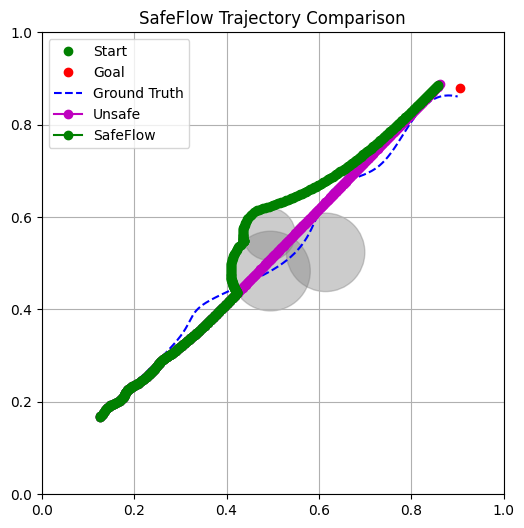

In [ ]:

visualize_safe_vs_unsafe(trained_model, dataset, sample_idx=0)


